# Прогноз продаж игр интернет-магазина на 2017 год

- Дано: исторические данные из открытых источников о продажах игр до 2016 года, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). 
- Цель: выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st

## Знакомство с общей информацией

In [2]:
data = pd.read_csv('/Users/games.csv')

In [3]:
display(data.head())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


## Подготовка данных

### Приведение названий столбцов к нижнему регистру:

In [5]:
data.columns = data.columns.str.lower()

### Удаление строк с пропусками данных в столбце `name`.

In [6]:
# пропусков всего 2 и точное восстановление невозможно:
data = data.dropna(subset=['name']).reset_index(drop=True)

### Обработка пропусков данных в столбце `year_of_release`

In [7]:
# группирую по названию игры и выбираю минимальный год. Оставшиеся удаляю, т.к. восстановить не получится:
df_gr = data.groupby('name')['year_of_release'].min()

def year(row):
    name = row['name']
    if name in df_gr.index:
        return df_gr[name]
    return 0

data.loc[data['year_of_release'].isna(), 'year_of_release'] = data.loc[data['year_of_release'].isna()].apply(year, axis = 1)

data = data.dropna(subset=['year_of_release']).reset_index(drop=True)

### Замена пропусков данных в столбце `critic_score`

In [8]:
# заменяю на медианные значения, сгруппировав по названию игры:
median_cr_sc = data.groupby('name')['critic_score'].median()
for nam in data['name'].unique():
    data.loc[data['name'] == nam, 'critic_score'] = data.loc[data['name'] == nam, 'critic_score'].fillna(median_cr_sc[nam])
    
# заменяю на медианные значения, сгруппировав по платформе:
median_cr_sc = data.groupby('platform')['critic_score'].median()
for plat in data['platform'].unique():
    data.loc[data['platform'] == plat, 'critic_score'] = data.loc[data['platform'] == plat, 'critic_score'].fillna(median_cr_sc[plat])

### Замена `tbd` в столбце `user_score` 

In [9]:
# 'tbd' - аббр. "требует уточнения". Т.к. восстановить не получится - заменю на NaN:
data['user_score'] = data['user_score'].replace('tbd', np.NaN)

### Преобразование типов данных в столбцах:
 - с типом данных float64 во float32, для меньшей загрузки оперативной памяти
 - `user_score` во float32 для вычислений
 - `year_of_release` в целочисленные значения

In [10]:
for col in ['na_sales', 'eu_sales','jp_sales','other_sales','critic_score', 'user_score']:
    data[col] = data[col].astype('float32')

data['year_of_release'] = data['year_of_release'].astype('Int32')

### Замена пропусков данных в столбце `user_score`

In [11]:
# заменяю на медианные значения, сгруппировав по названию игры:
median_us_sc = data.groupby('name')['user_score'].median()
for nam in data['name'].unique():
    data.loc[data['name'] == nam, 'user_score'] = data.loc[data['name'] == nam, 'user_score'].fillna(median_us_sc[nam])

# заменяю на медианные значения, сгруппировав по платформе:
median_us_sc = data.groupby('platform')['user_score'].median()
for plat in data['platform'].unique():
    data.loc[data['platform'] == plat, 'user_score'] = data.loc[data['platform'] == plat, 'user_score'].fillna(median_us_sc[plat])

### Удаление оставшихся пропусков в `user_score` и `critic_score`:

In [12]:
data = data.dropna(subset=['user_score']).reset_index(drop=True)

### Обработка пропусков данных в столбце `year_of_release`

In [13]:
# группирую по названию игры и выбираю минимальный год.
df_gr = data.groupby('name')['rating']

def year(row):
    name = row['name']
    if name in df_gr.index:
        return df_gr[name]
    return 0

data.loc[data['year_of_release'].isna(), 'year_of_release'] = data.loc[data['year_of_release'].isna()].apply(year, axis = 1)

#  оставшиеся удаляю, т.к. восстановить не получится:
data = data.dropna(subset=['year_of_release']).reset_index(drop=True)

### Замена пропусков данных в столбце `rating` 

In [14]:
# заменяю на UNDEF (англ. Undefined - не определено), сгруппировав по названию игры:
data['rating'] = data['rating'].fillna('UNDEF')

### Подсчет суммарных продаж во всех регионах:

In [15]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16536 entries, 0 to 16535
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16536 non-null  object 
 1   platform         16536 non-null  object 
 2   year_of_release  16536 non-null  Int32  
 3   genre            16536 non-null  object 
 4   na_sales         16536 non-null  float32
 5   eu_sales         16536 non-null  float32
 6   jp_sales         16536 non-null  float32
 7   other_sales      16536 non-null  float32
 8   critic_score     16536 non-null  float32
 9   user_score       16536 non-null  float32
 10  rating           16536 non-null  object 
 11  total_sales      16536 non-null  float32
dtypes: Int32(1), float32(7), object(4)
memory usage: 1.0+ MB


## Исследовательский анализ данных

### Выпуск игр по годам:

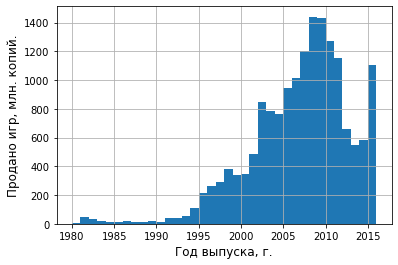

In [17]:
data['year_of_release'].hist(bins=36, range= (1980,2016))
plt.plot()
plt.xlabel('Год выпуска, г.', fontsize='large', color='black')
plt.ylabel('Продано игр, млн. копий.', fontsize='large', color='black')
plt.show()

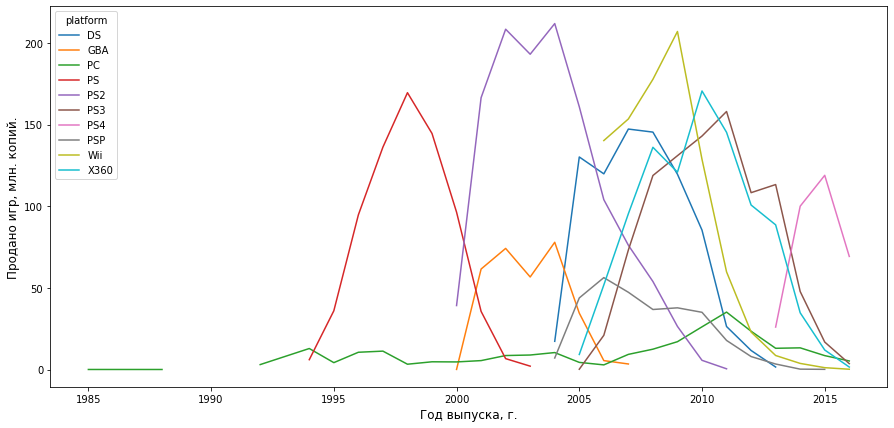

In [18]:
platform_totalsales = data.pivot_table(index='platform', values='total_sales', aggfunc='sum')\
                            .nlargest(10, 'total_sales').index

data.query('platform in @platform_totalsales').pivot_table(index = 'year_of_release',\
                            columns = 'platform', values= 'total_sales', aggfunc = 'sum').plot(figsize = (15,7))
plt.xlabel('Год выпуска, г.', fontsize='large', color='black')
plt.ylabel('Продано игр, млн. копий.', fontsize='large', color='black')
plt.show()

Рост выпуска игр стартовал в начале 90-х годов, с пиком в 2009-2010 гг. Далее, судя по всему, количество выпускаемых игр переросло в качество, чему поспособствовал прогресс ЭВМ и игровых платформ.
Средняя продолжительность жизни платформы ~ 7 лет.
Для дальнейшего анализа мне потребуются данные с "современными" играми, т.е за последние ~ 5 лет. 

In [19]:
data = data[data['year_of_release'] >= 2013]

### График продаж для ТОР-10 платформ начиная с 2013 года:

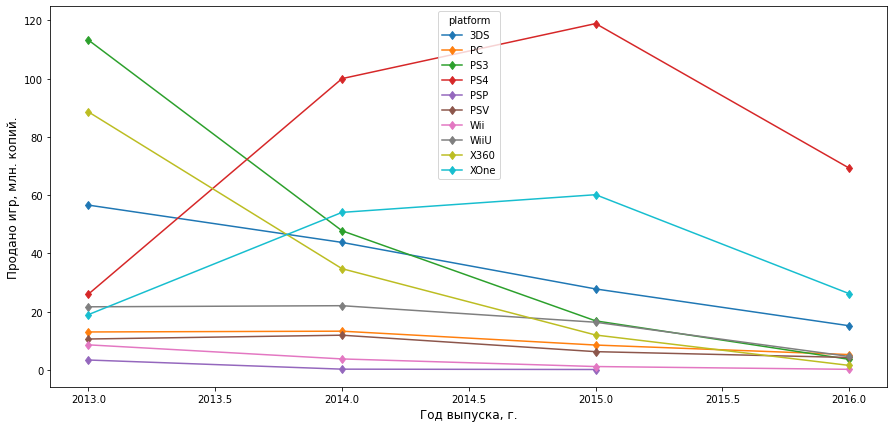

In [20]:
platform_totalsales = data.pivot_table(index='platform',\
                                       values='total_sales', aggfunc='sum').nlargest(10, 'total_sales').index

data.query('platform in @platform_totalsales').\
pivot_table(index = 'year_of_release', columns = 'platform', \
            values= 'total_sales', aggfunc = 'sum').plot(figsize = (15,7), marker='d')
plt.xlabel('Год выпуска, г.', fontsize='large', color='black')
plt.ylabel('Продано игр, млн. копий.', fontsize='large', color='black')
plt.show()

- На графике видно, что в лидерах продаж на начало 2015 года 3 платфомы: Sony PS4, Xbox One, Nintendo 3DS. При этом первые две показывают рост, а Nintendo стагнирует с 2013 года. 
- В 2014 году тройку лидеров замыкала PS3, но вышедшее в 2013 году обновление платформы от Sony рисует "крест" на графике PS3-PS4 (такой же "крест" рисует Xbox One со своим предшественником Xbox 360).
- Вероятно, что по причине неполных данных за 2016 год все платформы показывают падение относительно 2015 года.
- Учитывая эту информацию и среднюю продолжительность жизни платформы могу предположить, что Sony PS4 и Xbox One продолжат рост в 2017 году.

### Диаграмма размаха:

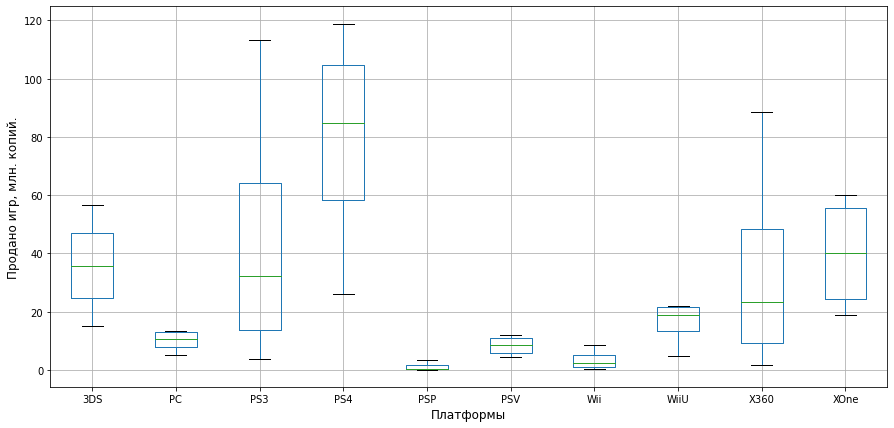

In [21]:
platform_totalsales = data.pivot_table(index='platform',\
                                       values='total_sales', aggfunc='sum').nlargest(10, 'total_sales').index

data.query('platform in @platform_totalsales').\
pivot_table(index = 'year_of_release', columns = 'platform', \
            values= 'total_sales', aggfunc = 'sum').boxplot(figsize = (15,7))
plt.xlabel('Платформы', fontsize='large', color='black')
plt.ylabel('Продано игр, млн. копий.', fontsize='large', color='black')
plt.show()

На диаграмме видно, что за период с 2013 года тройка лидером суммарным продажам: Sony PS3, Sony PS4, Xbox 360

### Влияние отзывов критиков и пользователей на продажи игр на платформе PS4

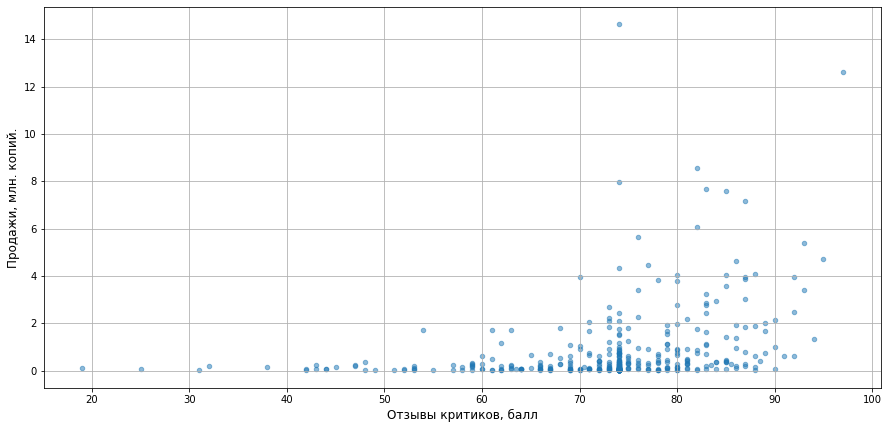

Коэффициент корреляции: 0.31872149649602655


In [22]:
data.query('platform == "PS4" and critic_score > 0').plot(x='critic_score', y='total_sales', grid=True,\
                                                figsize=(15,7), kind='scatter', alpha=0.5)
plt.plot()
plt.xlabel('Отзывы критиков, балл', fontsize='large', color='black')
plt.ylabel('Продажи, млн. копий.', fontsize='large', color='black')
plt.show()
print('Коэффициент корреляции:', data.query('platform == "PS4" and critic_score > 0')['critic_score']\
      .corr(data.query('platform == "PS4" and critic_score > 0')['total_sales']))

Вывод: наблюдается положительная корреляция между отзывами критиков и продажами.

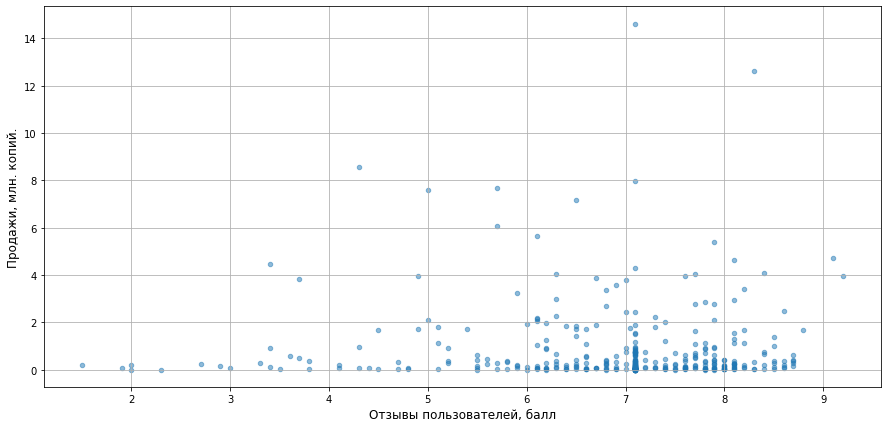

Коэффициент корреляции: -0.028937353039389907


In [23]:
data.query('platform == "PS4" and user_score > 0').plot(x='user_score', y='total_sales', grid=True,\
                                                figsize=(15,7), kind='scatter', alpha=0.5)
plt.plot()
plt.xlabel('Отзывы пользователей, балл', fontsize='large', color='black')
plt.ylabel('Продажи, млн. копий.', fontsize='large', color='black')
plt.show()
print('Коэффициент корреляции:', data.query('platform == "PS4" and user_score > 0')['user_score']\
      .corr(data.query('platform == "PS4" and user_score > 0')['total_sales']))

Вывод: наблюдается отрицательная корреляция между отзывами пользователей и продажами.

### Влияние отзывов критиков и пользователей на продажи игр на других платфомах

PS4


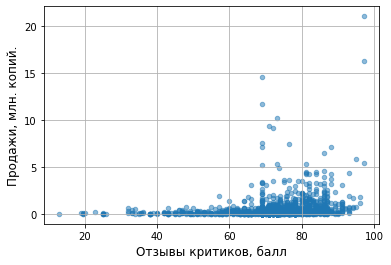

Корреляция равна: 0.21682472112095205
PS3


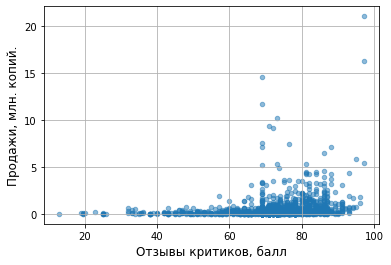

Корреляция равна: 0.21682472112095205
XOne


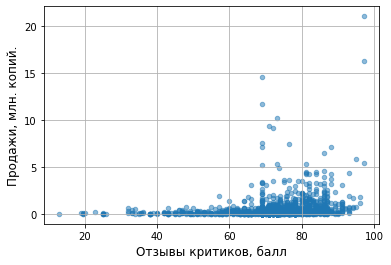

Корреляция равна: 0.21682472112095205
3DS


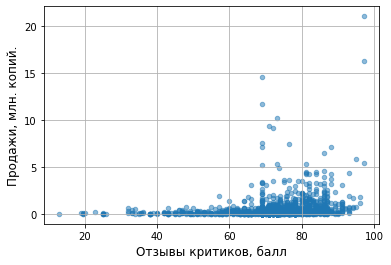

Корреляция равна: 0.21682472112095205
X360


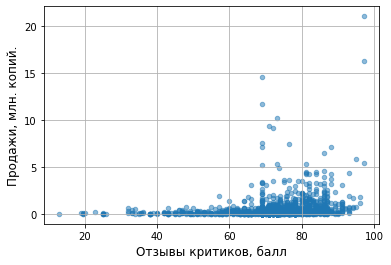

Корреляция равна: 0.21682472112095205
WiiU


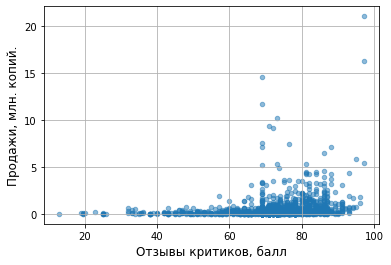

Корреляция равна: 0.21682472112095205


In [24]:
data_other_plat = (data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .nlargest(6, 'total_sales').index)
for pl in data_other_plat:
    print(pl)
    (data.query('platform != "PS4" and critic_score > 0')
        .plot(kind='scatter', x='critic_score', y='total_sales', grid=True, alpha=0.5))
    plt.plot()
    plt.xlabel('Отзывы критиков, балл', fontsize='large', color='black')
    plt.ylabel('Продажи, млн. копий.', fontsize='large', color='black')
    plt.show()
    print('Корреляция равна:', (data.query('platform != "PS4" and critic_score > 0')['critic_score']
        .corr(data.query('platform != "PS4" and critic_score > 0')['total_sales'])))

PS4


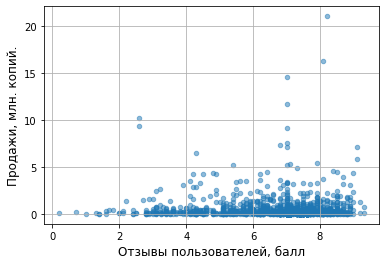

Корреляция равна: -0.04044671181206913
PS3


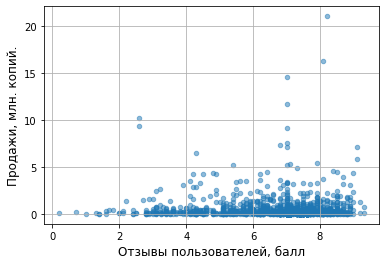

Корреляция равна: -0.04044671181206913
XOne


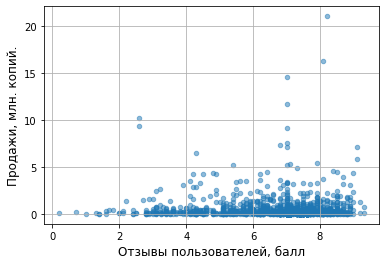

Корреляция равна: -0.04044671181206913
3DS


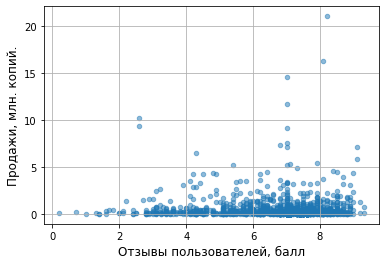

Корреляция равна: -0.04044671181206913
X360


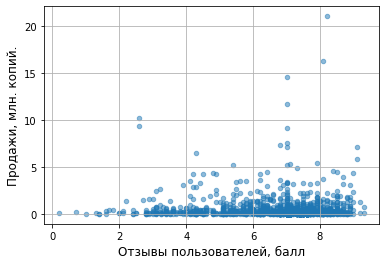

Корреляция равна: -0.04044671181206913
WiiU


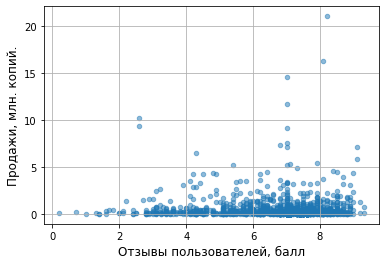

Корреляция равна: -0.04044671181206913


In [25]:
data_other_plat = (data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .nlargest(6, 'total_sales').index)
for pl in data_other_plat:
    print(pl)
    (data.query('platform != "PS4" and user_score > 0')
        .plot(kind='scatter', x='user_score', y='total_sales', grid=True, alpha=0.5))
    plt.plot()
    plt.xlabel('Отзывы пользователей, балл', fontsize='large', color='black')
    plt.ylabel('Продажи, млн. копий.', fontsize='large', color='black')
    plt.show()
    print('Корреляция равна:', (data.query('platform != "PS4" and user_score > 0')['user_score']
        .corr(data.query('platform != "PS4" and user_score > 0')['total_sales'])))

Вывод: на других платформах наблюдается аналогичные корреляции, как и у лидера по количеству продаж.

### Распределение игр по жанрам

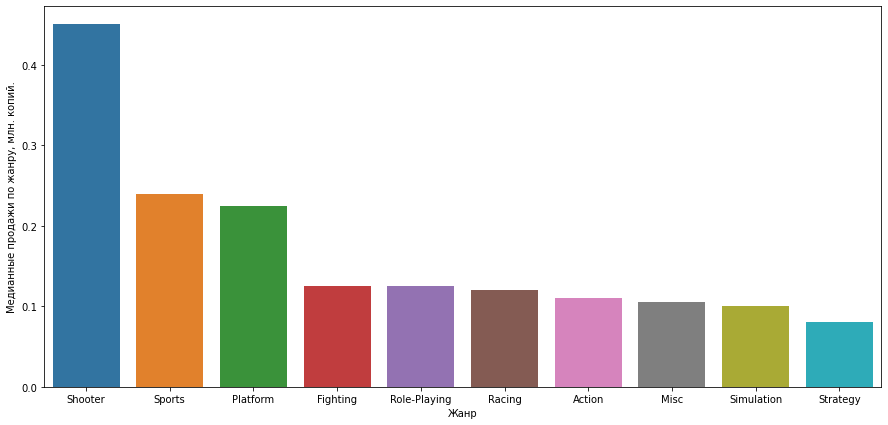

In [26]:
data_gr = data.groupby('genre')['total_sales'].median().to_frame().nlargest(10, 'total_sales')
data_gr = data_gr.sort_values('total_sales', ascending=False).reset_index()
plt.figure(figsize=(15,7))
sns.barplot(x='genre', y='total_sales', data=data_gr)
plt.xlabel('Жанр')
plt.ylabel('Медианные продажи по жанру, млн. копий.')
plt.show()

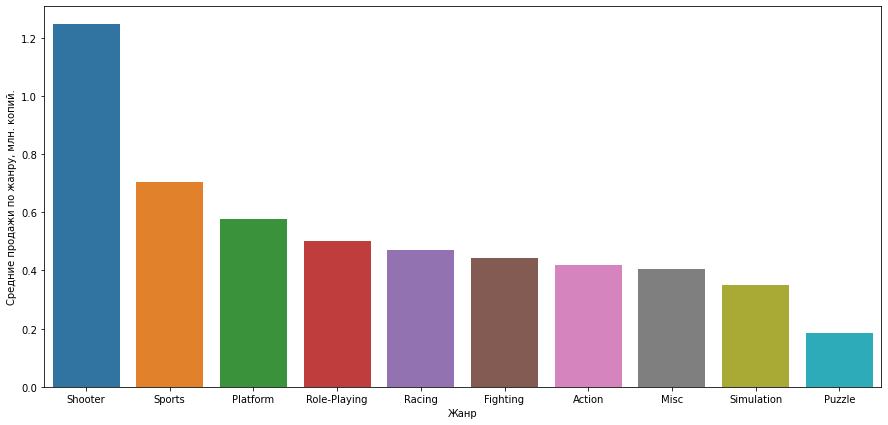

In [27]:
data_gr = data.groupby('genre')['total_sales'].mean().to_frame().nlargest(10, 'total_sales')
data_gr = data_gr.sort_values('total_sales', ascending=False).reset_index()
plt.figure(figsize=(15,7))
sns.barplot(x='genre', y='total_sales', data=data_gr)
plt.xlabel('Жанр')
plt.ylabel('Средние продажи по жанру, млн. копий.')
plt.show()

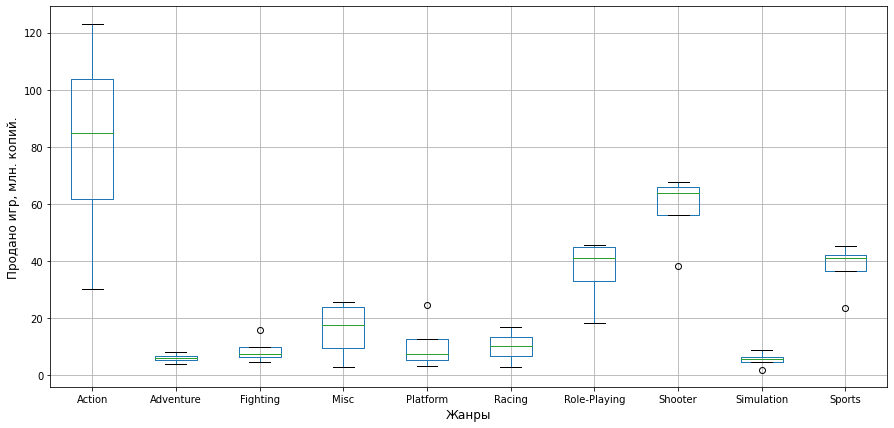

In [28]:
genre_totalsales = data.pivot_table(index='genre',\
                                       values='total_sales', aggfunc='sum').nlargest(10, 'total_sales').index

data.query('genre in @genre_totalsales').\
pivot_table(index = 'year_of_release', columns = 'genre',\
            values= 'total_sales', aggfunc = 'sum').boxplot(figsize = (15,7))
plt.xlabel('Жанры', fontsize='large', color='black')
plt.ylabel('Продано игр, млн. копий.', fontsize='large', color='black')
plt.show()

Тройки лидирующих жанров по продажам:
- по медианным  значениям: Shooter, Sports, Platform
- по средним значениям: Shooter, Sports, Platform
- по диаграмме распределения: Action, Shooter, Sports

## Портрет пользователя каждого региона

### Самые популярные платформы (топ-5)

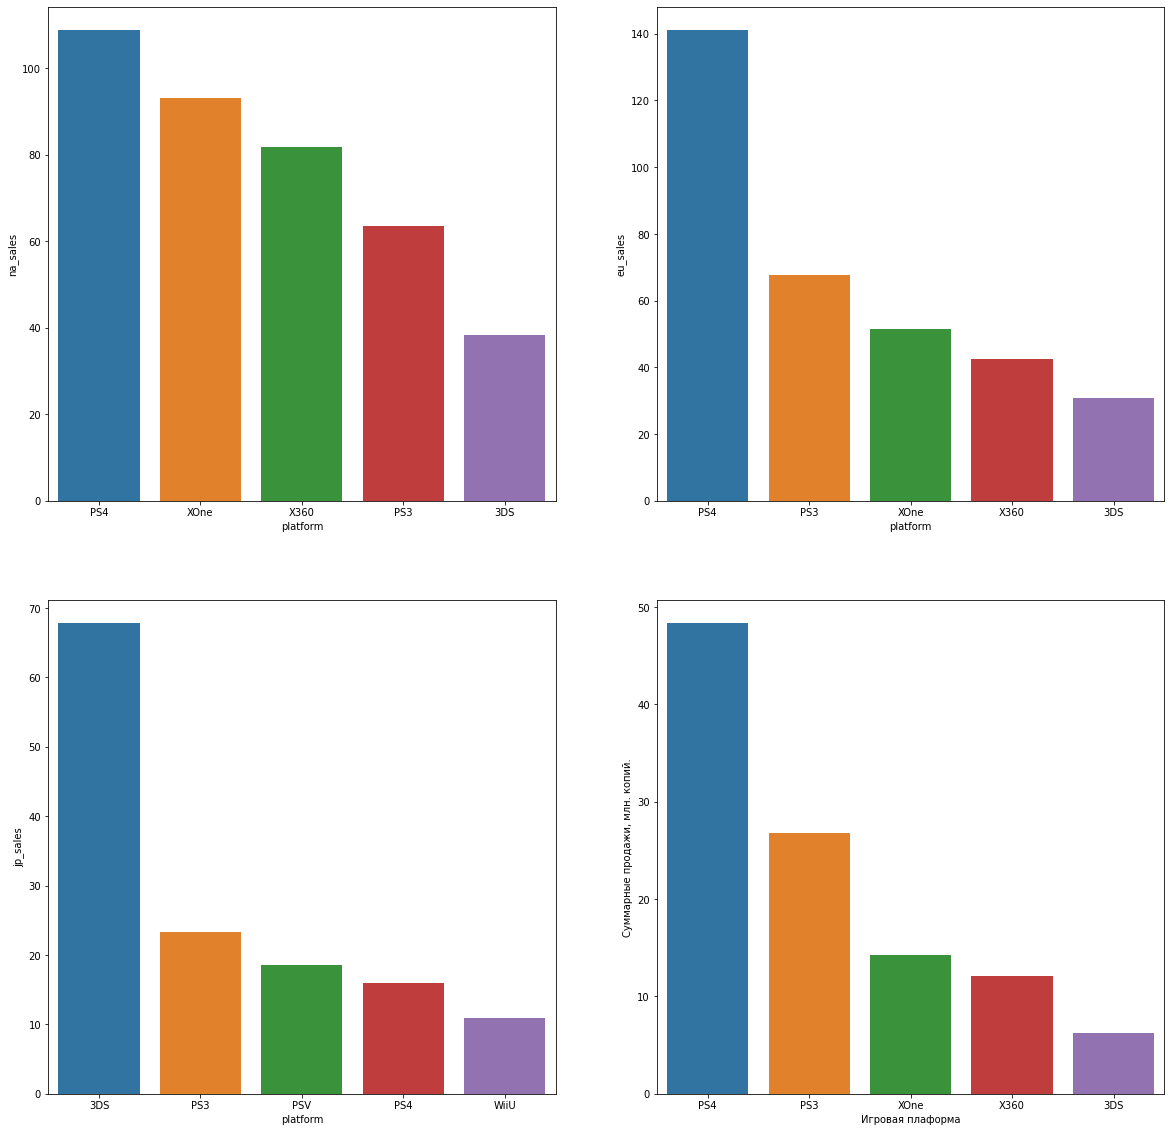

In [29]:
regions = [['na_sales', 'eu_sales'],['jp_sales','other_sales']]
fig , ax = plt.subplots(nrows = 2, ncols = 2, figsize=(20,20))
for i in [0, 1]:
    for j in [0, 1]:
        a = data.groupby(['platform'])[regions[i][j]].sum().to_frame().sort_values(by = regions[i][j], ascending=False).reset_index().nlargest(5, regions[i][j])
        sns.barplot(data = a, x ='platform', y = regions[i][j], ax = ax[i, j])
    plt.xlabel('Игровая плаформа')
    plt.ylabel('Суммарные продажи, млн. копий.')
plt.show()

Глобально по продажам лидирует PS4, в Японии Nintendo 3DS

### Самые популярные жанры (топ-5)

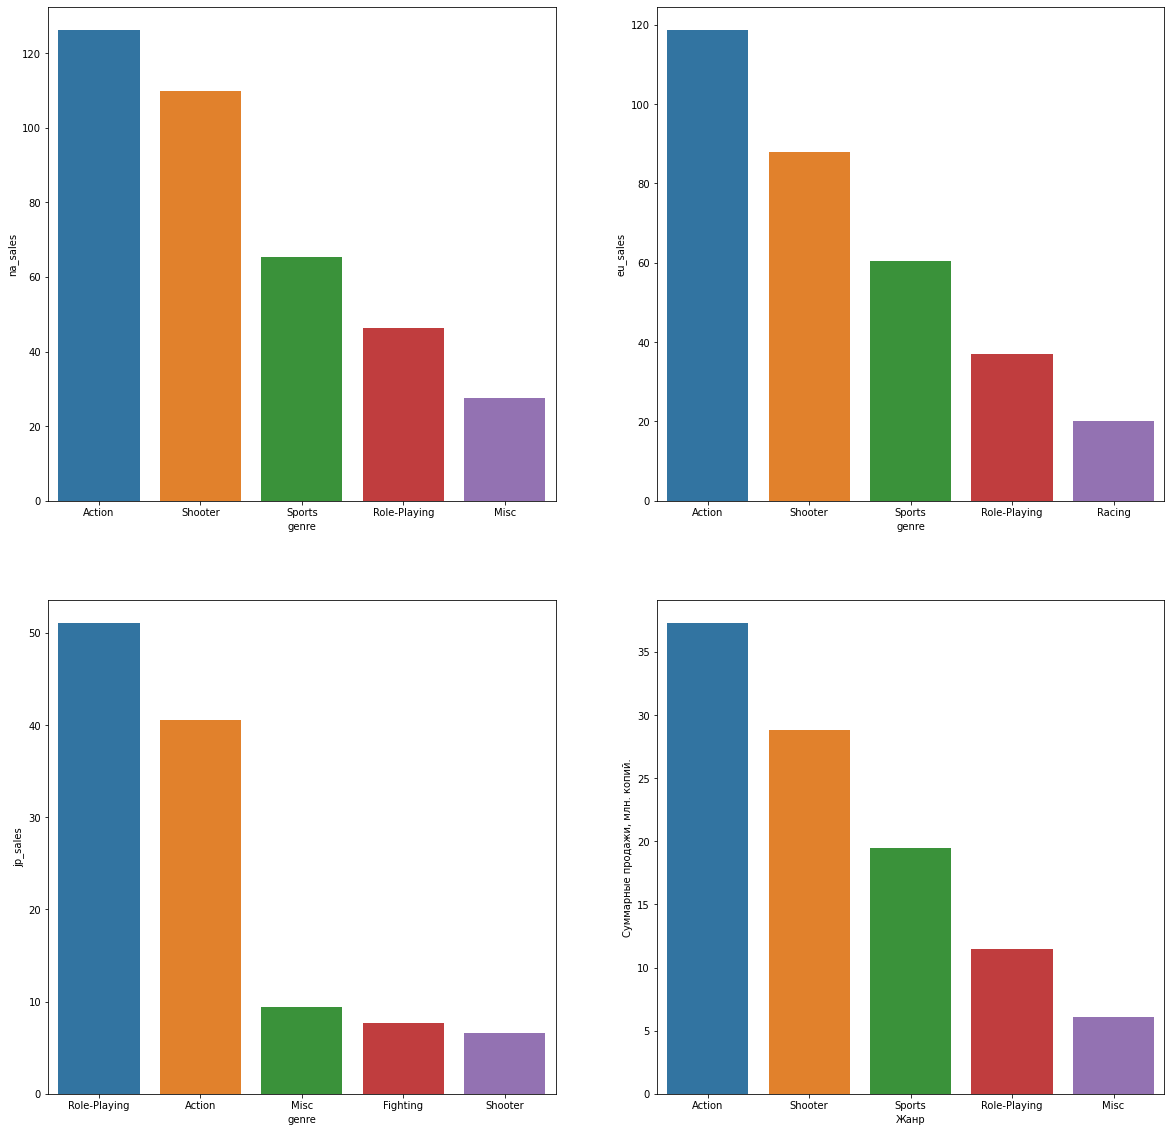

In [30]:
regions = [['na_sales', 'eu_sales'],['jp_sales','other_sales']]
fig , ax = plt.subplots(nrows = 2, ncols = 2, figsize=(20,20))
for i in [0, 1]:
    for j in [0, 1]:
        a = data.groupby(['genre'])[regions[i][j]].sum().to_frame().sort_values(by = regions[i][j], ascending=False).reset_index().nlargest(5, regions[i][j])
        sns.barplot(data = a, x ='genre', y = regions[i][j], ax = ax[i, j])
        plt.xlabel('Жанр')
        plt.ylabel('Суммарные продажи, млн. копий.')
plt.show()

- Во всех регионах, кроме Японии, оформилась тройка лидеров из жанров Action, Shooter, Sports. 
- В Японии лидируют Role-Playing, Action и Misc (сокр. от "Miscellaneous game" с англ. разнообразные игры)

### Влияние рейтинга ESRB на продажи в отдельном регионе

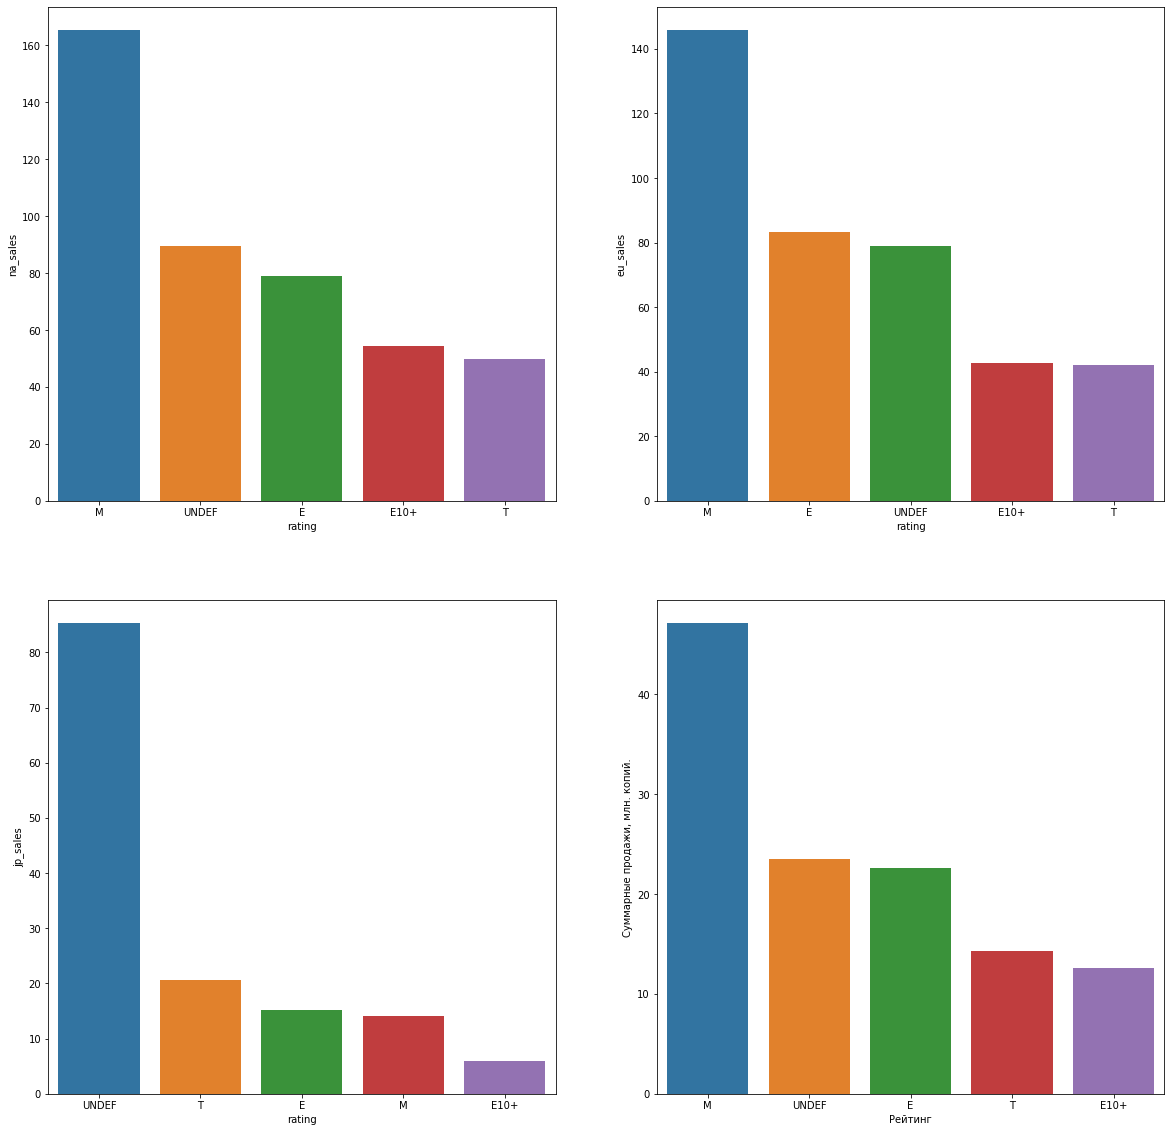

In [31]:
regions = [['na_sales', 'eu_sales'],['jp_sales','other_sales']]
fig , ax = plt.subplots(nrows = 2, ncols = 2, figsize=(20,20))
for i in [0, 1]:
    for j in [0, 1]:
        a = data.groupby(['rating'])[regions[i][j]].sum().to_frame().sort_values(by = regions[i][j], ascending=False).reset_index().nlargest(5, regions[i][j])
        sns.barplot(data = a, x ='rating', y = regions[i][j], ax = ax[i, j])
        plt.xlabel('Рейтинг')
        plt.ylabel('Суммарные продажи, млн. копий.')
plt.show()

Во всем мире (кроме Японии с UNDEF) со значительным отрывом лидируют продажи игр с категорией "M" ("Mature") — "Для взрослых"

## Проверка гипотез

### Проверка гипотезы: средние пользовательские рейтинги платформ Xbox One и PC одинаковые

- H_0: средние пользовательские рейтинги платформы "Xbox One" (user_score) = пользовательские рейтинги платформы "PC"
- H_a: средние пользовательские платформы "Xbox One" (user_score) ≠ пользовательские рейтинги платформы "PC"
- alpha = 0.05

In [32]:
xone = data.query('platform == "XOne" and user_score != 0')['user_score']
pc = data.query('platform == "PC" and user_score != 0')['user_score']

results = st.ttest_ind(xone, pc, equal_var = False)

alpha = .05

print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.22216563502321074
Не получилось отвергнуть нулевую гипотезу


### Проверка гипотезы: cредние пользовательские рейтинги жанров Action и Sports разные.

- H_0: средние пользовательские (user_score) рейтинги жанра "Action" ≠ пользовательские рейтинги жанра "Sports"
- H_a: средние пользовательские (user_score) рейтинги жанра "Action" = пользовательские рейтинги жанра "Sports"
- alpha = 0.05

In [33]:
action = data.query('genre == "Action" and user_score != 0')['user_score']
sports = data.query('genre == "Sports" and user_score != 0')['user_score']

results = st.ttest_ind(action, sports, equal_var = False)

alpha = .05

print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

4.636333828946841e-26
Отвергаем нулевую гипотезу


## Вывод

- Рост выпуска игр стартовал в начале 90-х годов, с пиком в 2009-2010 гг. Далее, судя по всему, количество выпускаемых игр переросло в качество, чему поспособствовал прогресс ЭВМ и игровых платформ. Средняя продолжительность жизни платформы ~ 7 лет. Для дальнейшего анализа мне потребуются данные с "современными" играми, т.е за последние ~ 5 лет.
- В лидерах продаж на начало 2015 года 3 платфомы: Sony PS4, Xbox One, Nintendo 3DS. При этом первые две показывают рост, а Nintendo стагнирует с 2013 года. 
- В 2014 году тройку лидеров замыкала PS3, но вышедшее в 2013 году обновление платформы от Sony рисует "крест" на графике PS3-PS4 (такой же "крест" рисует Xbox One со своим предшественником Xbox 360).
- Вероятно, что по причине неполных данных за 2016 год все платформы показывают падение относительно 2015 года.
- Учитывая эту информацию и среднюю продолжительность жизни платформы могу предположить, что Sony PS4 и Xbox One продолжат рост в 2017 году.
- За период с 2013 года тройка лидером суммарным продажам: Sony PS3, Sony PS4, Xbox 360
- Наблюдается положительная корреляция между отзывами критиков и продажами.
- Наблюдается отрицательная корреляция между отзывами пользователей и продажами.
- Глобально по продажам лидирует PS4, в Японии Nintendo 3DS
- Во всех регионах, кроме Японии, оформилась тройка лидеров из жанров Action, Shooter, Sports. 
- В Японии лидируют Role-Playing, Action и Misc (сокр. от "Miscellaneous game" с англ. разнообразные игры)
- Во всем мире (кроме Японии с UNDEF) со значительным отрывом лидируют продажи игр с категорией "M" ("Mature") — "Для взрослых"
- Не получилось отвергнуть гипотезу : средние пользовательские рейтинги платформ Xbox One и PC одинаковые 
- Отвергаем гипотезу: cредние пользовательские рейтинги жанров Action и Sports разные.
